# Catalog Debiasing of Astrometric Observations of Minor Planets
#### This notebook shows how to debias astrometric observations of minor planets reduced with pre-Gaia era astrometric catalog following [Eggl et al. (2020)](https://www.sciencedirect.com/science/article/pii/S0019103519305329?casa_token=VEVn27uSEEcAAAAA:NKzfb7a4Dtyu_aMOd1WNQze5VUhe75SeLU4EO8n1nQ_yjkacDKAMvZSIyYS6ll14G9RbwpJS5w)


In [1]:
import healpy as hp

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### The astrocat_debiasing module contains the necessary routines to debias RADEC observations.

In [3]:
import astrocat_debiasing.debias as ad

In [4]:
help(ad)

Help on package debias:

NAME
    debias

PACKAGE CONTENTS
    debias

FILE
    /Users/rahil/grad/projects/keyholes/grss/extern/astrocat_debiasing/debias/__init__.py




#### We need to read in a bias data table such as the one [linked here](ftp://ssd.jpl.nasa.gov/pub/ssd/debias/debias_hires2018.tgz). 

In [5]:
!head -n 26 bias.dat

! BIAS_VERSION= 3.0 (September 25, 2018)
! NSIDE= 256 
! NPIX= 786432 
! Catalogs in this file (MPC designation):
! a b c d e g i j l m n o p q r t u v w L N Q R S U W 

! This file contains position [arcsec] and proper motion [mas/yr] corrections with respect to Gaia-DR2.
! The Righ Ascension corrections include the cos(Declination) factor.
! The healpix tesselation resolution of the bias maps is NSIDE.

! JPL SSD does not debias the following catalogs:
! Gaia-DR1
! ACT
! Tycho-2
! UCAC-5
! Reference: Eggl et al., Icarus, 2019

! The current version of the reader ignores empty lines and lines
! starting with a '!' and treats all other lines as data.
! The BIAS_VERSION (with '=' appended) tag will be output if found.

! |-----  USNO-A1.0 a  -----|  |-----  USNO-SA1.0 b -----|  |-----  USNO-A2.0 c  -----|  |-----  USNO-SA2.0 d -----|  |-----    UCAC-1 e   -----|  |-----   Tycho-2 g   -----|  |-----   GSC-1.1 i   -----|  |-----   GSC-1.2 j   -----|  |-----     ACT l     -----|  |-----   

#### Let us use pandas for this purpose. We should also define the headers to make them compatiable with pandas. The units for biases in RADEC are arcseconds ["], and for the proper motion arcseconds per year ["/yr].

In [6]:
mpc_catalogs = ['a', 'b', 'c', 'd', 'e', 'g', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 't', 'u', 'v', 'w', 'L', 'N', 'Q', 'R', 'S', 'U', 'W']
columns = []

for cat in mpc_catalogs:
    columns.extend([cat+"_ra",cat+"_dec",cat+"_pm_ra",cat+'_pm_dec'])

biasdf=pd.read_csv('bias.dat',sep='\s+',skiprows=23,names=columns)

In [7]:
biasdf.head()

,a_ra,a_dec,a_pm_ra,a_pm_dec,b_ra,b_dec,b_pm_ra,b_pm_dec,c_ra,c_dec,...,S_pm_ra,S_pm_dec,U_ra,U_dec,U_pm_ra,U_pm_dec,W_ra,W_dec,W_pm_ra,W_pm_dec
0,0.098,0.151,-0.22,-0.49,0.094,0.154,-0.26,-0.50,-0.040,-0.021,...,2.81,-0.27,0.003,0.007,-0.19,-0.45,-0.005,-0.002,0.36,0.15
1,0.124,-0.078,-0.50,0.32,0.120,-0.069,-0.50,0.29,-0.104,0.081,...,2.31,0.16,0.006,-0.004,-0.37,0.29,-0.008,-0.002,0.51,0.12
2,-0.127,-0.092,0.28,0.56,-0.134,-0.085,0.29,0.54,-0.020,0.113,...,3.97,1.22,-0.005,-0.006,0.34,0.40,-0.007,-0.004,0.45,0.25
3,-0.155,0.133,0.55,-0.22,-0.158,0.136,0.54,-0.19,0.029,0.018,...,3.91,1.29,-0.007,0.005,0.50,-0.32,-0.004,-0.005,0.28,0.36
4,0.100,0.256,-0.08,-0.78,0.100,0.260,-0.10,-0.78,-0.020,-0.048,...,2.59,-0.37,0.002,0.011,-0.11,-0.74,-0.005,-0.003,0.35,0.23


#### We can plot the scatter in biases for catalog c.

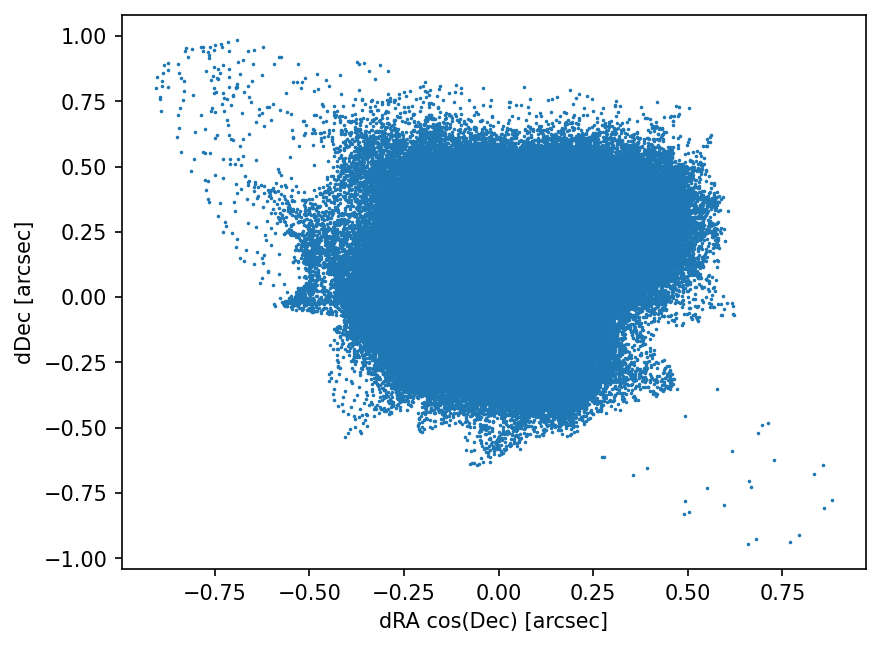

In [8]:
x=biasdf['c_ra']
y=biasdf['c_dec']
plt.figure(dpi=150)
plt.scatter(x,y,s=0.5)
plt.xlabel('dRA cos(Dec) [arcsec]')
plt.ylabel('dDec [arcsec]')
plt.show()

#### Let us debias a single RADEC value. The input and output angle units are [rad]. Please be sure that the nside variable here corresponds to the nside variable in the header of the bias.dat file. 

In [9]:
ra=1
dec=np.pi/4
epoch= 2451545.0+10000
catalog = 'g'

ra_new, dec_new = ad.debiasRADec(ra,dec,epoch,catalog,biasdf,nside=256)

In [10]:
ra_new,dec_new

(1.000000410250987, 0.7853980862257363)

#### Finally, multiple observations can be debiased like so:

In [11]:
ra = np.array([0,1,2])
dec = np.array([0.1,0.8,-0.1])
epoch = np.array([2451546.0,2459545.0,2460545.0])
catalog = np.array(['c','d','W'])


In [12]:
ndat = len(ra)
ra_deb = np.zeros(ndat)
dec_deb = np.zeros(ndat)

for i in range(ndat):
      ra_deb[i],dec_deb[i] = ad.debiasRADec(ra[i],dec[i],epoch[i],catalog[i],biasdf,J2000=2451545.0,nside=256)

In [13]:
print(ra_deb,dec_deb)

[6.28318525 0.99999991 2.00000004] [ 0.09999877  0.79999862 -0.10000001]
